# <font color='green'><b> Hough Transform and Corner Detection </b></font>


### Credits: Hands-on Image Processing with Python, Chapter 7 and 8 - Author: Sandipan Dey



## <font color='green'><b>Base Dir setup</b></font>

In [4]:
#@title ▶️ Base dir setup
import os, sys

# check if hosted (Google VM) or running on local server
if 'google.colab' in sys.modules:
  #@markdown Google Drive root folder - hosted by Google VM (adapt to your local paths)
  from google.colab import drive
  drive.mount('/content/drive', force_remount=False)
  base_dir = 'infoMM/' #@param {type: "string"}
  base_dir  = os.path.join('/content/drive/MyDrive/', base_dir)
  #!pip install pillow  --upgrade
  img_dir = 'data/img/'
  vid_dir = 'data/video/'
  out_dir = 'output/'
  
  # move to base_dir 
  os.chdir(base_dir)
else:
  #@markdown Path to local folder on PC (adapt to your local paths)
  img_dir = '../Immagini_IN/'
  out_dir = '../Immagini_OUT/'

 

print("Current dir:", os.getcwd())

Current dir: c:\Users\eumir\Desktop\Università\Anno III\Semestre 1\Informazione Multimediale\Lab 7


In [3]:
import cv2
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import os
import plotly.express as px       # TUTORIAL: https://plotly.com/python/getting-started/
import plotly.graph_objects as go
from skimage.transform import (hough_line, hough_line_peaks, hough_circle, hough_circle_peaks)
from skimage.feature import corner_harris, corner_subpix, corner_peaks
from skimage.draw import circle_perimeter
from skimage.feature import canny
from skimage.io import imread, imsave
from skimage.color import rgb2gray, gray2rgb, label2rgb
from skimage import img_as_float, img_as_ubyte
import math
 

In [5]:
def multiPlots(images, titles= [], nCols = 2):

  '''multiPlots funtion allows to plot a list of images organized on nCols, with possible titles'''

  nImg =len(images)
  nRows = math.ceil(nImg/nCols) 
  f = plt.figure(figsize=(15,5*nRows))

  for n, image in enumerate(images): 
    row = int(n/nCols)+1
    col = n%nCols+1
    ax = f.add_subplot(nRows, nCols, n+1)
    ax.imshow(image)   
    plt.axis('off')
    if titles:
      plt.title(titles[n]) 

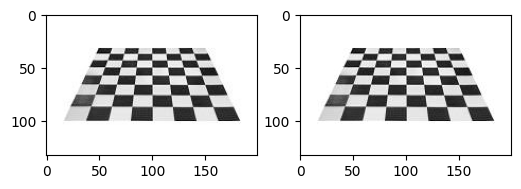

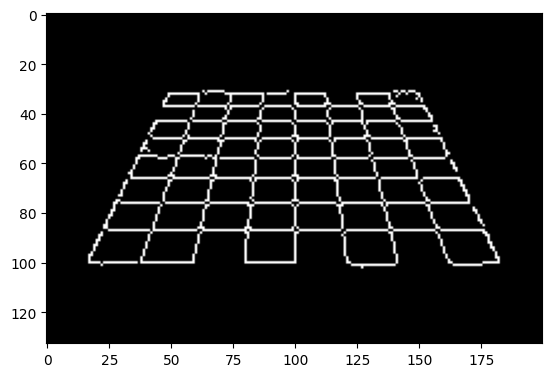

In [6]:
# load an example image 
img = imread(img_dir + 'chessboard_projection.jpg') # chessboard_projection.jpg  #umbc_lib.jpg 
 

# show image (RGB and Gray)
plt.figure(figsize=(6,6))
plt.subplot(121)
plt.imshow(img)
grayImg = img_as_ubyte(rgb2gray(img))
 
plt.subplot(122)
plt.imshow(grayImg, cmap='gray')
plt.show()

edges = cv2.Canny(grayImg,50,150 )
plt.imshow(edges, cmap='gray')
plt.show()

## <font color='green'><b>Hough Line Transform with *Opencv* library</b></font>
 
`HoughLines(dst, lines, rho, theta, threshold, 0, 0 );` 

INPUT:

- dst: Output of the edge detector. It should be a grayscale image (although in fact it is a binary one)

- lines: A vector that will store the parameters (r,θ) of the detected lines

- rho : The resolution of the parameter r in pixels. We use 1 pixel.

- theta: The resolution of the parameter θ in radians. We use 5 degrees: 5*(CV_PI/180)

- threshold: The minimum number of intersections to "*detect*" a line

- srn and stn: Default parameters to zero. Check OpenCV reference for more info.

In [1]:
def line_extremes(rho, theta):
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    return x1, y1, x2, y2

lines shape: (48, 2)


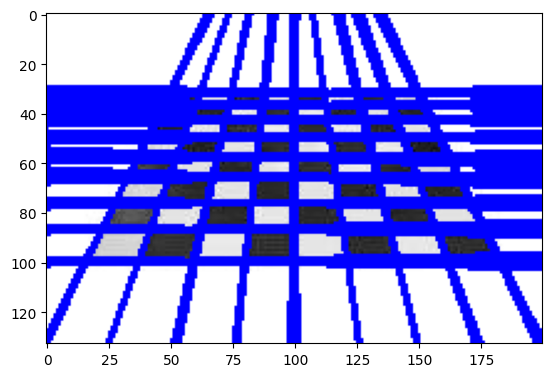

In [7]:
lines = cv2.HoughLines(edges,1, 1*np.pi/180,40) #for the image 'umbc_lib.jpg' set the last param to 200
lines = lines.squeeze()
print(f"lines shape: {lines.shape}")
 
imgLines = img.copy( ); 
for i in range(len(lines)):
    rho =  lines[i][0]; 
    theta =  lines[i][1];
    x1, y1, x2, y2 = line_extremes(rho, theta)
    cv2.line(imgLines,(x1,y1),(x2,y2),(0,0,255),2)

plt.imshow(imgLines);

##### <font color='green'><b>EXERCISE 1: </b></font>

Given the output of the Hough Line transform, select and plot only the quasi-vertical lines.

And if you would be interested in quasi-horizontal lines?

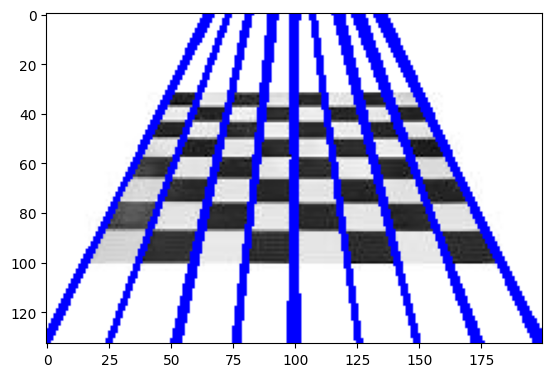

In [21]:
#TO DO
imgLines = img.copy( ); 
for i in range(len(lines)):
    rho =  lines[i][0]; 
    theta =  lines[i][1];
    thetarad = theta/np.pi * 180 #trasformo il theta in gradi
    
    if thetarad > 150 or thetarad < 30:
    #if thetarad > 89 and thetarad < 92: per le righe quasi orizzontali  
        x1, y1, x2, y2 = line_extremes(rho, theta)
        cv2.line(imgLines,(x1,y1),(x2,y2),(0,0,255),2)

plt.imshow(imgLines);

## <font color='green'><b>Hough Circle Transform with *Opencv* library</b></font>

https://docs.opencv.org/3.4/d3/de5/tutorial_js_houghcircles.html
 
Parameters

INPUT

- image:	8-bit, single-channel, grayscale input image.

- method:	detection method(see cv.HoughModes). Currently, the only implemented method is HOUGH_GRADIENT

- dp:	inverse ratio of the accumulator resolution to the image resolution. For example, if dp = 1 , the accumulator has the same resolution as the input image. If dp = 2 , the accumulator has half as big width and height.

- $\textbf{minDist}$:	minimum distance between the centers of the detected circles. If the parameter is too small, multiple neighbor circles may be falsely detected in addition to a true one. If it is too large, some circles may be missed.

- param1:	first method-specific parameter. In case of HOUGH_GRADIENT , it is the higher threshold of the two passed to the Canny edge detector (the lower one is twice smaller).

- $\textbf{param2}$:	second method-specific parameter. In case of HOUGH_GRADIENT , it is the accumulator threshold for the circle centers at the detection stage. The smaller it is, the more false circles may be detected. Circles, corresponding to the larger accumulator values, will be returned first.

- $\textbf{minRadius}$:	minimum circle radius.
- $\textbf{maxRadius}$:	maximum circle radius.

OUTPUT:

- circles:	output vector of found circles(cv.CV_32FC3 type). Each vector is encoded as a 3-element floating-point vector (x,y,radius) .


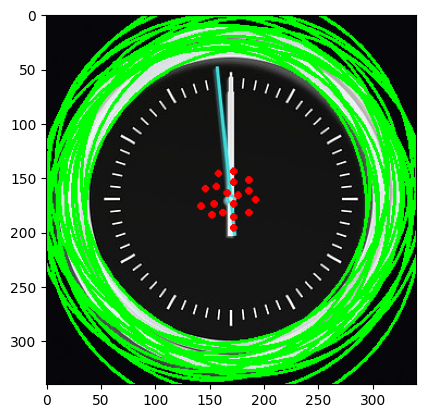

In [22]:
img = imread(img_dir + 'clock2.jpg')  #'triangle_circle.jpg') #'cycle.jpg') 

grayImg =img_as_ubyte(rgb2gray(img))
grayImgBlur = cv2.medianBlur(grayImg,5)
h, w = grayImgBlur.shape
cimg = img.copy()

#params for 'cycle.jpg'
#circles = cv2.HoughCircles(grayImgBlur,cv2.HOUGH_GRADIENT, 1,minDist=10,
#                            param1=50,param2=40,minRadius=30,maxRadius=60)

#params for 'clock2.jpg'
circles = cv2.HoughCircles(grayImgBlur,cv2.HOUGH_GRADIENT, 1,minDist=10,
                            param1=60,param2=50,minRadius=150,maxRadius=200)


#params for 'tringle_circle.jpg'
#circles = cv2.HoughCircles(grayImgBlur,cv2.HOUGH_GRADIENT, 1,10,
#                            param1=50,param2=40,minRadius=10,maxRadius=200)

if circles is not None:
  circles = circles.squeeze()

#pd=1: same resolution as the input image
#minDist=20: min distance among the centers of the detected circles
#param1, and param2: threshold for canny histeresis
#min/maxRadius: range of radius circles we are interested in 
 
  circles = np.uint16(np.around(circles))  
 
  for i in circles[:]:
      # draw the outer circle
      cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
      # draw the center of the circle
      cv2.circle(cimg,(i[0],i[1]),2,(255,0,0),2) 
  plt.imshow(cimg) 
else:
  print('No circle found')
 

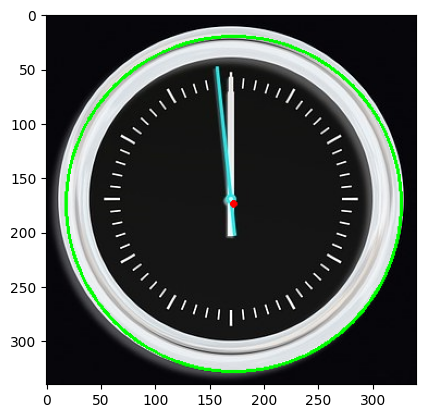

In [23]:
bestCircle = img.copy()

#circles.shape 
# draw the outer circle
cv2.circle(bestCircle,(circles[0,0],circles[0,1]), circles[0,2],(0,255,0),2)
# draw the center of the circle
cv2.circle(bestCircle,(circles[0,0],circles[0,1]),2,(255,0,0),2) 
plt.imshow(bestCircle) 

##### <font color='green'><b>EXERCISE 3: </b></font>
Given the circles produced by the Hough Circle Transform, choose the one with:

- either the lowest standard deviation 
- or ON the circonference or WITHIN it, and plot only the selected one

In [25]:
#GIVEN
def maskCirconf(img, circle):
  '''given an image 'img' and a 'circle'  mask the value in "img" outside the circonference, and return the selected values
     INPUT: 
          - img: gray scale img
          - circle: the coordinate (x,y) of the circle center, and the radius'''
 
  mask = np.zeros_like(img)
  cv2.circle(mask,(circle[0],circle[1]),circle[2],1)
  return mask

In [26]:
#GIVEN
def maskCircle(img, circle):
    '''given an image 'img' and a 'circle', mask the value in "img" outside the given circle, and return the selected values
       INPUT: 
            - img: gray scale img
            - circle: the coordinate (x,y) of the circle center, and the radius'''
  
    h, w = img.shape    
    Y, X = np.ogrid[:h, :w]
   
    dist_from_center = np.sqrt((X - circle[0])**2 + (Y-circle[1])**2)

    mask = dist_from_center <= circle[2]
  
    return mask

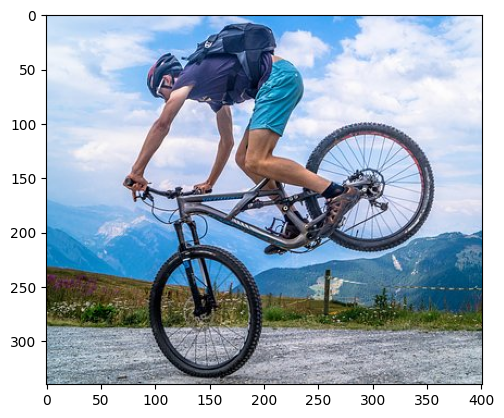

In [44]:
#GIVEN

img = imread(img_dir + 'cycle.jpg') # 'clock2.jpg')   #'cycle.jpg') 

grayImg =img_as_ubyte(rgb2gray(img))
grayImgBlur = cv2.medianBlur(grayImg,5)
circles = cv2.HoughCircles(grayImgBlur,cv2.HOUGH_GRADIENT, 1,minDist=10,
                            param1=50,param2=40,minRadius=30,maxRadius=60)

circles = circles.squeeze()
circles = np.round(circles).astype(int)

cimg = img.copy() 
plt.imshow(cimg)
min_std = float('Inf')
r =  circles[0]; 

eval_Circonf = 0 #1: eval the std along the circonference
                 #0: eval the std in the circle

 

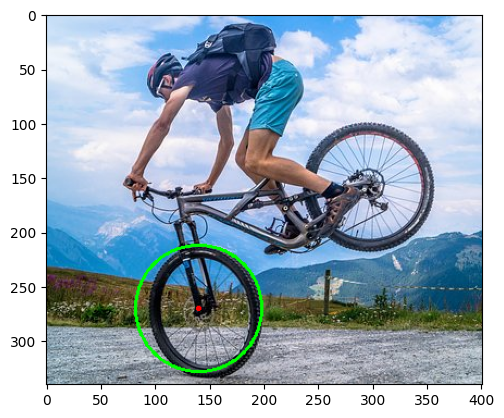

In [45]:
#TO DO:
min = 9999.99
index = 0
# 1. loop on all circles
for i in circles[:]:
  
  # 1.1 for each circle, mask the circonference or the circle
  mask = maskCirconf(cimg,i)
  
  #1.2 compute the ste on the masked pixels
  stdev = np.std(cimg[mask])
  
  #print(stdev)
  if stdev < min:
    min = stdev
    mincircle = i
 
#1.3 remember the circonference corresponding to the lowest std
#print(mincircle)

#2 draw the circle and the center
cv2.circle(cimg, (mincircle[0],mincircle[1]), mincircle[2],(0,255,0), 2)
# draw the outer circle
 
# draw the center of the circle
cv2.circle(cimg, (mincircle[0],mincircle[1]), 1,(255,0,0), 2)

#3 plot the circle
plt.imshow(cimg)

## <font color='gray'><b>Hough Transforms with *Skimage* library  </b></font>


In [ ]:
image = rgb2gray(imread(img_dir + 'triangle_circle.png'))

# Classic straight-line Hough transform
h, theta, d = hough_line(image)

# Generating figure 1
fig, axes = plt.subplots(2, 2, figsize=(20, 20))
ax = axes.ravel()

ax[0].imshow(image, cmap=cm.gray)
ax[0].set_title('Input image', size=20)
ax[0].set_axis_off()

ax[1].imshow(np.log(1 + h),
             extent=[10*np.rad2deg(theta[-1]), np.rad2deg(theta[0]), d[-1], d[0]],
             cmap=cm.hot, aspect=1/1.5)
ax[1].set_title('Hough transform', size=20)
ax[1].set_xlabel('Angles (degrees)', size=20)
ax[1].set_ylabel('Distance (pixels)', size=20)
ax[1].axis('image')

ax[2].imshow(image, cmap=cm.gray)
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - image.shape[1] * np.cos(angle)) / np.sin(angle)
    ax[2].plot((0, image.shape[1]), (y0, y1), '-r')
ax[2].set_xlim((0, image.shape[1]))
ax[2].set_ylim((image.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines', size=20)

hough_radii = np.arange(50, 100, 2)
hough_res = hough_circle(image, hough_radii)

# Select the most prominent 6 circles
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=6)

image = gray2rgb(image)
for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = circle_perimeter(center_y, center_x, radius)
    image[circy, circx] = (0.9, 0.2, 0.2)

ax[3].imshow(image, cmap=plt.cm.gray)
ax[3].set_axis_off()
ax[3].set_title('Detected Circles', size=20)

plt.tight_layout()
plt.show()

image = rgb2gray(imread(img_dir + 'coins.png'))

fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_axis_off()
ax[0].set_title('Original Image', size=20)

hough_radii = np.arange(65, 75, 1)
hough_res = hough_circle(image, hough_radii)

# Select the most prominent 5 circles
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=4)

image = gray2rgb(image)
for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = circle_perimeter(center_y, center_x, radius)
    image[circy, circx] = (1, 0, 0)

ax[1].imshow(image, cmap=plt.cm.gray)
ax[1].set_axis_off()
ax[1].set_title('Detected Circles', size=20)

plt.tight_layout()
plt.show()

## <font color='green'><b>Harris Corner Detector with the *Opencv* library</b></font> 

https://docs.opencv.org/3.4/dc/d0d/tutorial_py_features_harris.html

OpenCV has the function cv2.cornerHarris() for this purpose. Its arguments are :

- **img** - Input image, it should be grayscale and float32 type.
- **blockSize** - It is the size of neighbourhood considered for corner detection
- **ksize** - Aperture parameter of Sobel derivative used.
- **k** - Harris detector free parameter in the equation.
See the example below:

In [ ]:
# load an example image 
img =  imread(img_dir +  'chessboard_projection.jpg')
gray = img_as_ubyte(rgb2gray(img))
 
dst = cv2.cornerHarris(gray,blockSize=2, ksize=3 ,k=0.04) 
 
# Threshold for an optimal value, it may vary depending on the image.
output = img.copy();
output[dst>0.01*dst.max()]=[255,0,0]
# show image

plt.figure(figsize=(6,6))
plt.imshow(output, cmap='gray', vmin=0, vmax=255)
plt.show()

##### <font color='green'><b>EXERCISE 4: </b></font>

- load the image 'horse.jpg', 
- compute its corners setting the parameter: 
`dst = cv2.cornerHarris(gray,blockSize=3, ksize=3 ,k=0.04)`, and 
- crop the rectangle including the strongest corners (`threshold= 0.1*dst.max()`)

x1: 246 x2: 575 y1: 14 y2: 446


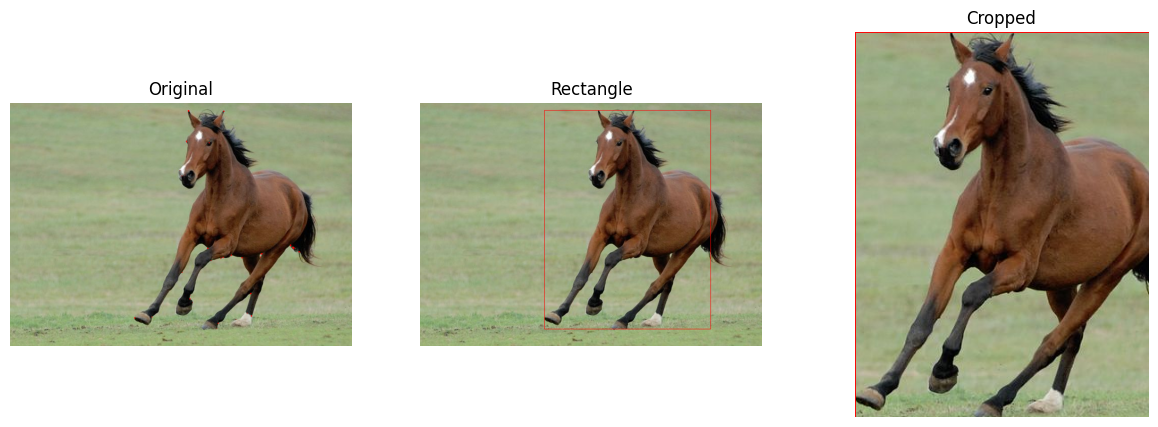

In [46]:
#TO DO

# 1. load an example image and convert to uint8 gray
img =  imread(img_dir +  'horse.jpg')
gray = img_as_ubyte(rgb2gray(img))

#adaptive threshpold to select the strongest corners
thresh = 0.1
# 2. compute the corners
dst = cv2.cornerHarris(gray,blockSize=3, ksize=3 ,k=0.04) 

# chechpoint 
output = img.copy();
output[dst>thresh*dst.max()]=[255,0,0] 
  
# 3. steps to crop the rectangle:

# 3.1 produce the list of point coordinates:
points= np.argwhere(dst>thresh*dst.max()) 

# 3.2 find  the bounding box around them. Hint: use  cv2.boundingRec()
y1,x1,h,w = cv2.boundingRect(points)
x2 = x1+w
y2 = y1+h

# checkpoint: Draw bounding rectangle. Hint: use cv2.rectangle()
start = (x1, y1)
end = (x2, y2)
colour = (255, 0, 0)
thickness = 1
rectangle_img = cv2.rectangle(img, start, end, colour, thickness)
print("x1:", x1, "x2:", x2, "y1:", y1, "y2:", y2)

# Crop the rectangle
crop = img[y1 :y2, x1:x2, :]
 
multiPlots([output, rectangle_img, crop], ['Original', 'Rectangle', 'Cropped'], 3)


## <font color='gray'><b>Harris Corner Detector with the *Skimage* library </b></font> 
 
https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.corner_harris

OpenCV has the function corner_harris(image, method='k', k=0.05, eps=1e-06, sigma=1) for this purpose. Its arguments are :

- **image** - Input image, it should be grayscale and float32 type.
- **method** - k or eps
- **k** - float, Sensitivity factor to separate corners from edges, typically in range [0, 0.2]. Small values of k result in detection of sharp corners.
- **eps** - float, Normalisation factor (Noble’s corner measure).
- **sigma** - float, Standard deviation used for the Gaussian kernel, which is used as weighting function for the auto-correlation matrix.


In [ ]:
img = imread(img_dir + 'chessboard_projection.jpg') # chessboard_projection.jpg  #Viale.jpg
grayImg = img_as_ubyte(rgb2gray(img))

coordinates = corner_harris(grayImg, k =0.1) 
img[coordinates>0.1*coordinates.max()]=[255,0,0]
plt.figure(figsize=(20,10))
plt.imshow(img), plt.axis('off'), plt.show()